In [545]:
#!/usr/bin/env python3 -u
# Copyright (c) 2017-present, Facebook, Inc.
# All rights reserved.
#
# This source code is licensed under the license found in the LICENSE file in
# the root directory of this source tree.
from __future__ import print_function

import argparse
import csv
import os

import numpy as np
import torch
from torch.autograd import Variable
import torch.backends.cudnn as cudnn
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets

import models
from utils import progress_bar
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
from tqdm import tqdm
import MixingFunctions

# parser = argparse.ArgumentParser(description='PyTorch CIFAR10 Training')
# parser.add_argument('--lr', default=0.1, type=float, help='learning rate')
# parser.add_argument('--resume', '-r', action='store_true',
#                     help='resume from checkpoint')
# parser.add_argument('--model', default="ResNet18", type=str,
#                     help='model type (default: ResNet18)')
# parser.add_argument('--name', default='0', type=str, help='name of run')
# parser.add_argument('--seed', default=0, type=int, help='random seed')
# parser.add_argument('--batch-size', default=128, type=int, help='batch size')
# parser.add_argument('--epoch', default=200, type=int,
#                     help='total epochs to run')
# parser.add_argument('--no-augment', dest='augment', action='store_false',
#                     help='use standard augmentation (default: True)')
# parser.add_argument('--decay', default=1e-4, type=float, help='weight decay')
# parser.add_argument('--alpha', default=1., type=float,
#                     help='mixup interpolation coefficient (default: 1)')
# args = parser.parse_args()

params = {
    "lr": .01,
    "resume": False,
    "model": "ResNet18",
    "name": "VerticalMix-3Sets-128-AdvsTrain-Eps(.32, .08)",
    "seed": 10,
    "batch_size": 128,
    "decay": 1e-4, 
    "augment": True,
    "epoch": 200,
#     "no_augment": False,
    "alpha": 1.,
}

# %cd ../../

In [546]:


# checkpoint = torch.load('./checkpoint/ckpt.t7' + params["name"] + '_'
#                             + str(params["seed"]), map_location='cpu')

# net_SampEps_32_10 = checkpoint['net']
# net_SampEps_32_10.cuda()

# Loading Data

In [547]:



use_cuda = torch.cuda.is_available()

best_acc = 0  # best test accuracy
start_epoch = 0  # start from epoch 0 or last checkpoint epoch

if params["seed"] != 0:
    torch.manual_seed(params["seed"])

# Data
print('==> Preparing data..')
if params["augment"]:
    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465),
                             (0.2023, 0.1994, 0.2010)),
    ])
else:
    print("no augmentation")
    transform_train = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465),
                             (0.2023, 0.1994, 0.2010)),
    ])


transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

trainset = datasets.CIFAR10(root='./data', train=True, download=False,
                            transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset,
                                          batch_size=params["batch_size"],
                                          shuffle=True, num_workers=8)

testset = datasets.CIFAR10(root='./data', train=False, download=False,
                           transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=100,
                                         shuffle=False, num_workers=8)

==> Preparing data..


# Creating Model 

In [548]:
# Model
if params["resume"]:
    # Load checkpoint.
    print('==> Resuming from checkpoint..')
    assert os.path.isdir('checkpoint'), 'Error: no checkpoint directory found!'
    checkpoint = torch.load('./checkpoint/ckpt.t7' + params["name"] + '_'
                            + str(params["seed"]), map_location='cpu')
    
    net = checkpoint['net']
    best_acc = checkpoint['acc']
    start_epoch = checkpoint['epoch'] + 1
    rng_state = checkpoint['rng_state']
    torch.set_rng_state(rng_state)
else:
    print('==> Building model..')
    net = models.__dict__[params["model"]]()

if not os.path.isdir('results'):
    os.mkdir('results')
logname = ('results/log_' + net.__class__.__name__ + '_' + params["name"] + '_'
           + str(params["seed"]) + '.csv')

if use_cuda:
    net = torch.nn.DataParallel(net)
    net.to('cuda:0')
    print(torch.cuda.device_count())
    cudnn.benchmark = True
    print('Using CUDA..')

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=params["lr"], momentum=0.9,
                      weight_decay=params["decay"])

==> Building model..
3
Using CUDA..


# Helping functions

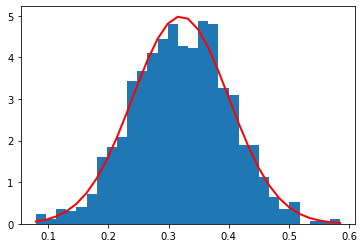

In [549]:
import matplotlib.pyplot as plt
mu, sigma = .32, .08
s = np.random.normal(mu, sigma, 1000)
# s = np.random.dirichlet(np.ones(2), 1000)[:,0]
count, bins, ignored = plt.hist(s, 30, density=True)
plt.plot(bins, 1/(sigma * np.sqrt(2 * np.pi)) *
               np.exp( - (bins - mu)**2 / (2 * sigma**2) ), linewidth=2, color='r')
plt.show()

In [550]:

def mixup_data(x, y, alpha=1.0, use_cuda=True, advs_train=False, epsilon=.35):
    '''Returns mixed inputs, pairs of targets, and lambda'''
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    batch_size = x.size()[0]
    if use_cuda:
        index = torch.randperm(batch_size).cuda()
    else:
        index = torch.randperm(batch_size)
    

    
    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    
    
    
    if advs_train:
        
        x_b = x[index, :]
        
        x_b.requires_grad_(True)
        x.requires_grad_(True)
        
        out_a = net(x)
        loss_a = criterion(out_a, y_a)
        optimizer.zero_grad()
        loss_a.backward()
        
        if type(epsilon) == tuple:
            epsilon = np.random.normal(epsilon[0], epsilon[1])
            
        
        err = torch.zeros_like(x)
        with torch.no_grad():
            err += epsilon * lam * x.grad.sign()

        out_b = net(x_b)
        loss_b = criterion(out_b, y_b)
        optimizer.zero_grad()
        loss_b.backward()
        
        with torch.no_grad():
            err += epsilon * (1 - lam) * x_b.grad.sign()
            
        mixed_x += err
        
        
        

    return mixed_x, y_a, y_b, lam


def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)


def mixup_criterion_nMixes(criterion, pred, mixed_targs, wts):
    '''Returns total criterion for total mixed images'''
    
    # accumulate total criterion as weighted sum of shuffled targets, weighted with wts 
    total_criterion = 0
    for i in range(len(wts)):
        total_criterion += wts[i]*criterion(pred, mixed_targs[:,i])
    return(total_criterion)


def advs_mix_err(x, mixed_targs, mixed_indices, wts, epsilon):
    n_mix = mixed_indices.shape[0]
    noise = torch.zeros_like(x)
    
    for i in range(n_mix):
        x_batch = x[mixed_indices[i]] # ith column of mix_indices have the indices of ith batch of mixed data.
        y_batch = mixed_targs[:, i]
        
        if type(epsilon) == tuple:
            epsilon = np.random.normal(epsilon[0], epsilon[1])
        
        noise += wts[i] * fgsm(x_batch, mixed_targs[:, i], epsilon)
        
    return noise


def train_mixup(epoch, mixup_func=mixup_data, nMix=2, advs_train=False , epsilon=.35):
    print('\nEpoch: %d' % epoch)
    net.train()
    train_loss = 0
    reg_loss = 0
    correct = 0
    total = 0
    
    if type(epsilon) == tuple:
        epsilon = np.random.normal(epsilon[0], epsilon[1])
    
    
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        if use_cuda:
            inputs, targets = inputs.cuda(), targets.cuda()
                 
        mixed_x, mixed_targs, mixed_noise, wts = mixup_func(inputs, targets, nMix, net, criterion, epsilon=epsilon, advs_train=advs_train)
        mixed_targs = mixed_targs.long()
        

        if advs_train == True:
            with torch.no_grad():
                mixed_x += mixed_noise
            

        outputs = net(mixed_x)
        
        loss = mixup_criterion_nMixes(criterion, outputs, mixed_targs, wts)
        
        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        
        for i, lam in enumerate(wts):
            correct += (lam * predicted.eq(mixed_targs[:, i].data).cpu().sum().float())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        progress_bar(batch_idx, len(trainloader),
                     'Loss: %.3f | Reg: %.5f | Acc: %.3f%% (%d/%d)'
                     % (train_loss/(batch_idx+1), reg_loss/(batch_idx+1),
                        100.*correct/total, correct, total))
    return (train_loss/batch_idx, reg_loss/batch_idx, 100.*correct/total)


def train_mixup_old(epoch, advs_train=False, epsilon=.35):
    print('\nEpoch: %d' % epoch)
    net.train()
    train_loss = 0
    reg_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        if use_cuda:
            inputs, targets = inputs.cuda(), targets.cuda()
                 
        inputs, targets_a, targets_b, lam = mixup_data(inputs, targets,
                                                       params["alpha"], use_cuda, 
                                                       advs_train=advs_train, epsilon=epsilon)
        
        inputs, targets_a, targets_b = map(Variable, (inputs,
                                                      targets_a, targets_b))
        outputs = net(inputs)
        loss = mixup_criterion(criterion, outputs, targets_a, targets_b, lam)
        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += (lam * predicted.eq(targets_a.data).cpu().sum().float()
                    + (1 - lam) * predicted.eq(targets_b.data).cpu().sum().float())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        progress_bar(batch_idx, len(trainloader),
                     'Loss: %.3f | Reg: %.5f | Acc: %.3f%% (%d/%d)'
                     % (train_loss/(batch_idx+1), reg_loss/(batch_idx+1),
                        100.*correct/total, correct, total))
    return (train_loss/batch_idx, reg_loss/batch_idx, 100.*correct/total)


def train_normal(epochs, advs_train=False , epsilon=.35, alpha=0.5):
    print('\nEpoch: %d' % epoch)
    net.train()
    train_loss = 0
    reg_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        if use_cuda:
            inputs, targets = inputs.cuda(), targets.cuda()
        
        outputs_normal = net(inputs)
        loss_normal = criterion(outputs_normal, targets)
        
        if advs_train:
            inputs_advs = inputs + fgsm(inputs, targets, eps=epsilon)
            outputs_advs = net(inputs_advs)
            loss_advs = criterion(outputs_advs, targets)
            loss = ((1 - alpha) * loss_advs) + (alpha * loss_normal)
        else:
            loss = loss_normal
        
        optimizer.zero_grad()
        loss.backward()
        
        train_loss += loss.item()
        _, predicted = torch.max(outputs_normal.data, 1)
        total += targets.size(0)
        correct += predicted.eq(targets.data).cpu().sum().float()

        optimizer.step()

        progress_bar(batch_idx, len(trainloader),
                     'Loss: %.3f | Reg: %.5f | Acc: %.3f%% (%d/%d)'
                     % (train_loss/(batch_idx+1), reg_loss/(batch_idx+1),
                        100.*correct/total, correct, total))
        
    return (train_loss/batch_idx, reg_loss/batch_idx, 100.*correct/total)


def fgsm(x, y, eps=.35):
    
    x.requires_grad_(True)
    out = net(x)
    loss = criterion(out, y)
    optimizer.zero_grad()
    loss.backward()
        
    with torch.no_grad():
        err = eps * x.grad.sign()    

    return err

def test(epoch):
    global best_acc
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(testloader):
        if use_cuda:
            inputs, targets = inputs.cuda(), targets.cuda()
#         inputs, targets = Variable(inputs, volatile=True), Variable(targets)
        outputs = net(inputs)
        loss = criterion(outputs, targets)

        test_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += predicted.eq(targets.data).cpu().sum()

        progress_bar(batch_idx, len(testloader),
                     'Loss: %.3f | Acc: %.3f%% (%d/%d)'
                     % (test_loss/(batch_idx+1), 100.*correct/total,
                        correct, total))
    acc = 100.*correct/total
    if acc > best_acc:
        best_acc = acc
        checkpoint(acc, epoch)

        
    return (test_loss/batch_idx, 100.*correct/total)


def checkpoint(acc, epoch):
    # Save checkpoint.
    print('Saving..')
    state = {
        'net': net,
        'acc': acc,
        'epoch': epoch,
        'rng_state': torch.get_rng_state()
    }
    if not os.path.isdir('checkpoint'):
        os.mkdir('checkpoint')
    torch.save(state, './checkpoint/ckpt.t7' + params["name"] + '_'
               + str(params["seed"]))


def adjust_learning_rate(optimizer, epoch):
    """decrease the learning rate at 100 and 150 epoch"""
    lr = params["lr"]
    if epoch >= 100:
        lr /= 10
    if epoch >= 150:
        lr /= 10
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

# Training the model

In [ ]:
import importlib
importlib.reload(MixingFunctions)


if not os.path.exists(logname):
    with open(logname, 'w') as logfile:
        logwriter = csv.writer(logfile, delimiter=',')
        logwriter.writerow(['epoch', 'train loss', 'reg loss', 'train acc',
                            'test loss', 'test acc'])

mu = .32
sig = .08
for epoch in range(start_epoch, params["epoch"]):
    train_loss, reg_loss, train_acc = train_mixup(epoch, mixup_func=MixingFunctions.vertical_concat_mix, nMix=3, advs_train=True, epsilon=(mu,sig))
#     train_loss, reg_loss, train_acc = train_mixup_old(epoch, advs_train=True, epsilon=(mu, sig))
    test_loss, test_acc = test(epoch)
    adjust_learning_rate(optimizer, epoch)
    with open(logname, 'a') as logfile:
        logwriter = csv.writer(logfile, delimiter=',')
        logwriter.writerow([epoch, train_loss, reg_loss, train_acc, test_loss,
                            test_acc])


Epoch: 0
 [=====================================================================================>]  Step: 209ms | Tot: 1m22s | Loss: 2.310 | Reg: 0.00000 | Acc: 11.220% (5609/50000 391/391 1  ========>.....................................................................]  Step: 203ms | Tot: 15s784ms | Loss: 2.383 | Reg: 0.00000 | Acc: 7.540% (723/9600 75/391 .........]  Step: 202ms | Tot: 55s332ms | Loss: 2.322 | Reg: 0.00000 | Acc: 10.568% (3516/33280 260/391 ................]  Step: 201ms | Tot: 58s164ms | Loss: 2.320 | Reg: 0.00000 | Acc: 10.676% (3744/35072 274/391 
 [=====================================================================================>]  Step: 37ms | Tot: 3s827ms | Loss: 2.147 | Acc: 24.060% (2406/10000 100/100 /10 12/100 
Saving..

Epoch: 1
 [=====================================================================================>]  Step: 210ms | Tot: 1m23s | Loss: 2.267 | Reg: 0.00000 | Acc: 13.988% (6993/50000 391/391 1  
 [=======================================

 [=====================================================================================>]  Step: 210ms | Tot: 1m23s | Loss: 1.864 | Reg: 0.00000 | Acc: 36.459% (18229/50000 391/391 1  
 [=====================================================================================>]  Step: 37ms | Tot: 3s825ms | Loss: 1.390 | Acc: 50.950% (5095/10000 100/100 ]  Step: 39ms | Tot: 1s483ms | Loss: 1.392 | Acc: 50.250% (2010/4000 40/100 48/100 ===============================================>..............................]  Step: 40ms | Tot: 2s497ms | Loss: 1.389 | Acc: 50.439% (3329/6600 66/10 85/100 

Epoch: 11
 [=====================================================================================>]  Step: 207ms | Tot: 1m23s | Loss: 1.818 | Reg: 0.00000 | Acc: 38.452% (19225/50000 391/391 1  >.............................................................................]  Step: 202ms | Tot: 8s13ms | Loss: 1.871 | Reg: 0.00000 | Acc: 34.982% (1746/4992 39/391 178/391 
 [==============================

 [=====================================================================================>]  Step: 41ms | Tot: 3s819ms | Loss: 1.242 | Acc: 57.400% (5740/10000 100/100 ......................................]  Step: 48ms | Tot: 277ms | Loss: 1.266 | Acc: 56.500% (452/800 8/100 27/10 33/100 ===>.........................................................]  Step: 44ms | Tot: 1s278ms | Loss: 1.243 | Acc: 57.618% (1959/3400 34/100 >..........................................]  Step: 40ms | Tot: 1s920ms | Loss: 1.241 | Acc: 57.314% (2923/5100 51/100 .................]  Step: 38ms | Tot: 1s959ms | Loss: 1.242 | Acc: 57.212% (2975/5200 52/100 ................]  Step: 44ms | Tot: 2s41ms | Loss: 1.242 | Acc: 57.241% (3091/5400 54/10 84/100 ........]  Step: 37ms | Tot: 3s408ms | Loss: 1.243 | Acc: 57.389% (5165/9000 90/100 =====>......]  Step: 38ms | Tot: 3s527ms | Loss: 1.243 | Acc: 57.452% (5343/9300 93/100 

Epoch: 18
 [================================================================================

 [=====================================================================================>]  Step: 39ms | Tot: 3s824ms | Loss: 1.212 | Acc: 60.480% (6048/10000 100/100 ==================================>...........................................]  Step: 40ms | Tot: 1s880ms | Loss: 1.213 | Acc: 60.440% (3022/5000 50/100 =========================================>......................................]  Step: 41ms | Tot: 2s122ms | Loss: 1.217 | Acc: 60.411% (3383/5600 56/100 ...................]  Step: 41ms | Tot: 2s242ms | Loss: 1.218 | Acc: 60.390% (3563/5900 59/100   Step: 44ms | Tot: 2s795ms | Loss: 1.216 | Acc: 60.260% (4399/7300 73/100 75/100 76/100 80/100 81/100 

Epoch: 25
 [=====================================================================================>]  Step: 208ms | Tot: 1m22s | Loss: 1.416 | Reg: 0.00000 | Acc: 55.319% (27659/50000 391/391 1  
 [=====================================================================================>]  Step: 38ms | Tot: 3s786ms | Loss: 1.06

In [ ]:
params = {
    "lr": .01,
    "resume": False,
    "model": "ResNet18",
    "name": "VerticalMix-3Sets-128-AdvsTrain-Eps(.32, .08)",
    "seed": 10,
    "batch_size": 128,
    "decay": 1e-4, 
    "augment": True,
    "epoch": 200,
#     "no_augment": False,
    "alpha": 1.,
}

# Model
if params["resume"]:
    # Load checkpoint.
    print('==> Resuming from checkpoint..')
    assert os.path.isdir('checkpoint'), 'Error: no checkpoint directory found!'
    checkpoint = torch.load('./checkpoint/ckpt.t7' + params["name"] + '_'
                            + str(params["seed"]), map_location='cpu')
    
    net = checkpoint['net']
    best_acc = checkpoint['acc']
    start_epoch = checkpoint['epoch'] + 1
    rng_state = checkpoint['rng_state']
    torch.set_rng_state(rng_state)
else:
    print('==> Building model..')
    net = models.__dict__[params["model"]]()

if not os.path.isdir('results'):
    os.mkdir('results')
logname = ('results/log_' + net.__class__.__name__ + '_' + params["name"] + '_'
           + str(params["seed"]) + '.csv')

if use_cuda:
    net = torch.nn.DataParallel(net)
    net.to('cuda:0')
    print(torch.cuda.device_count())
    cudnn.benchmark = True
    print('Using CUDA..')

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=params["lr"], momentum=0.9,
                      weight_decay=params["decay"])

import importlib
importlib.reload(MixingFunctions)


if not os.path.exists(logname):
    with open(logname, 'w') as logfile:
        logwriter = csv.writer(logfile, delimiter=',')
        logwriter.writerow(['epoch', 'train loss', 'reg loss', 'train acc',
                            'test loss', 'test acc'])

mu = .32
sig = .08
for epoch in range(start_epoch, params["epoch"]):
    train_loss, reg_loss, train_acc = train_mixup(epoch, mixup_func=MixingFunctions.vertical_concat_mix, nMix=3, advs_train=True, epsilon=(mu,sig))
#     train_loss, reg_loss, train_acc = train_mixup_old(epoch, advs_train=True, epsilon=(mu, sig))
    test_loss, test_acc = test(epoch)
    adjust_learning_rate(optimizer, epoch)
    with open(logname, 'a') as logfile:
        logwriter = csv.writer(logfile, delimiter=',')
        logwriter.writerow([epoch, train_loss, reg_loss, train_acc, test_loss,
                            test_acc])

# Robustness Evaluation

In [ ]:
def eval_robust(net, epsilon=0):

    net.to(f'cuda:{net.device_ids[0]}')
    net.eval()
    incorrect = 0
    total = 0
    
    for batch_idx, (normal_inpts, targets) in tqdm(enumerate(testloader)):
        if use_cuda:
            normal_inpts, targets = normal_inpts.cuda(), targets.cuda()
#             normal_inpts, targets = normal_inpts.to('cuda:1'), targets.to('cuda:1')
#         normal_inpts, targets = Variable(normal_inpts, volatile=True), Variable(targets)
        normal_inpts.requires_grad_(True)
        
        outputs = net(normal_inpts)
        loss = criterion(outputs, targets)
        
        optimizer.zero_grad()
        loss.backward()
        
        
        with torch.no_grad():
            advers_inp = normal_inpts + (epsilon * normal_inpts.grad.sign())
            advers_out = net(advers_inp)
#             print(advers_out.cpu().data.shape)
            normal_out = net(normal_inpts)
            _,advs_predicted = torch.max(advers_out.data, 1)
            _,normal_predicted = torch.max(normal_out.data, 1)
    

#         _, advs_predicted = torch.max(advs_predicted.data, 1)
        total += targets.size(0)
        incorrect += targets.size(0) - advs_predicted.eq(targets.data).sum()
    
    print(f'incorrects are: {incorrect} \ntotal is: {total} \nTop-1 error is {100.*incorrect/total}')
        
    return 100.*incorrect/total
#     acc = 100.*correct/total
#     return (test_loss/batch_idx, 100.*correct/total)

In [468]:
to_acc_tensor([eval_robust(net, 0)])

100it [00:09, 10.69it/s]

incorrects are: 511 
total is: 10000 
Top-1 error is 5.109999656677246


tensor([94.8900])

In [525]:
best_acc

tensor(86.9400)

In [76]:
def robust_eval_range(net, points=15, delta=.04):
    eps_list = [i * delta for i in list(range(points))]
    top_one_errs = []
    for i in eps_list:
        top_one_errs.append(eval_robust(net, i))
    return top_one_errs, eps_list

In [133]:
def to_acc_tensor(arr):
    return 100 - torch.cat([i.reshape(1) for i in arr]).cpu()

In [412]:
# err_norm_advs, eps_list = robust_eval_range(net_norm_adv)
# err35, eps_list = robust_eval_range(net35)
# err25, eps_list = robust_eval_range(net25)
# err45, eps_list = robust_eval_range(net45)
# err_mixup, eps_list = robust_eval_range(net)
# err_erm_noadvs, eps_list = robust_eval_range(net_ERM_noadvs)
# err_SampEps_32_08, eps_list = robust_eval_range(net_SampEps_32_10)
# err05, eps_list = robust_eval_range(net)
# err_SampEpsBeta_1_1, eps_list = robust_eval_range(net)
# err_SampEps_32_08_linear_3samp, eps_list = robust_eval_range(net)
# err_NoAdvs_linear_3samp, eps_list = robust_eval_range(net)

100it [00:09, 10.84it/s]

incorrects are: 584 
total is: 10000 
Top-1 error is 5.839999675750732



100it [00:09, 10.92it/s]

incorrects are: 5187 
total is: 10000 
Top-1 error is 51.869998931884766



100it [00:09, 11.07it/s]

incorrects are: 5920 
total is: 10000 
Top-1 error is 59.19999694824219



100it [00:09, 10.70it/s]


incorrects are: 6281 
total is: 10000 
Top-1 error is 62.80999755859375


100it [00:09, 10.98it/s]

incorrects are: 6608 
total is: 10000 
Top-1 error is 66.08000183105469



100it [00:09, 10.90it/s]

incorrects are: 6936 
total is: 10000 
Top-1 error is 69.36000061035156



100it [00:09, 10.99it/s]

incorrects are: 7259 
total is: 10000 
Top-1 error is 72.58999633789062



100it [00:09, 10.85it/s]

incorrects are: 7534 
total is: 10000 
Top-1 error is 75.33999633789062



100it [00:09, 10.81it/s]

incorrects are: 7825 
total is: 10000 
Top-1 error is 78.25



100it [00:09, 10.98it/s]

incorrects are: 8068 
total is: 10000 
Top-1 error is 80.68000030517578



100it [00:09, 10.95it/s]


incorrects are: 8258 
total is: 10000 
Top-1 error is 82.57999420166016


100it [00:09, 11.03it/s]

incorrects are: 8434 
total is: 10000 
Top-1 error is 84.33999633789062



100it [00:09, 10.72it/s]

incorrects are: 8563 
total is: 10000 
Top-1 error is 85.62999725341797



100it [00:09, 10.97it/s]


incorrects are: 8677 
total is: 10000 
Top-1 error is 86.7699966430664


100it [00:09, 10.91it/s]

incorrects are: 8770 
total is: 10000 
Top-1 error is 87.69999694824219


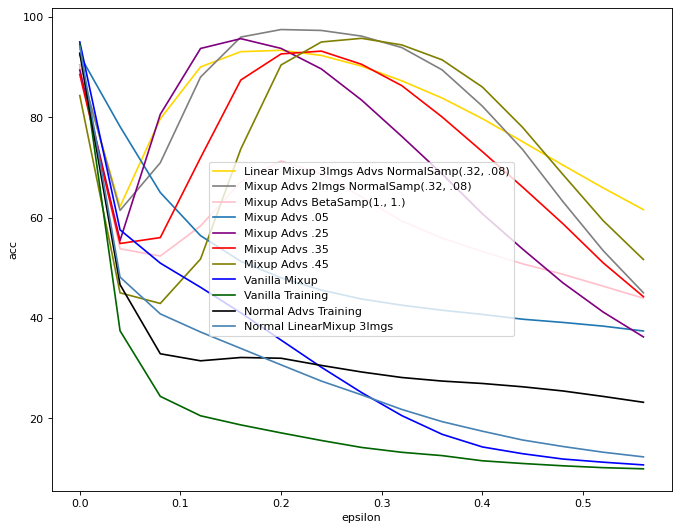

In [414]:
from matplotlib.pyplot import figure

figure(figsize=(10, 8), dpi=80)

plt.xlabel('epsilon'); plt.ylabel('acc');


plt.plot(eps_list, to_acc_tensor(err_SampEps_32_08_linear_3samp), c='gold')
plt.plot(eps_list, to_acc_tensor(err_SampEps_32_08), c='gray')
plt.plot(eps_list, to_acc_tensor(err_SampEpsBeta_1_1), c='pink')
plt.plot(eps_list, to_acc_tensor(err05))
plt.plot(eps_list, to_acc_tensor(err25), c='purple')
plt.plot(eps_list, to_acc_tensor(err35), c='r')
plt.plot(eps_list, to_acc_tensor(err45), c='olive')
plt.plot(eps_list, to_acc_tensor(err_mixup), c='b')
plt.plot(eps_list, to_acc_tensor(err_erm_noadvs), c = 'darkgreen')
plt.plot(eps_list, to_acc_tensor(err_norm_advs), c='black')
plt.plot(eps_list, to_acc_tensor(err_NoAdvs_linear_3samp), c='steelblue')

plt.legend(['Linear Mixup 3Imgs Advs NormalSamp(.32, .08)', 'Mixup Advs 2Imgs NormalSamp(.32, .08)', 'Mixup Advs BetaSamp(1., 1.)', 'Mixup Advs .05', 'Mixup Advs .25', 'Mixup Advs .35', 'Mixup Advs .45', 'Vanilla Mixup', 'Vanilla Training', 'Normal Advs Training', 'Normal LinearMixup 3Imgs']);


In [164]:
def imshow(img):
#     img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
#     plt.imshow(npimg)
    plt.show()

In [418]:
import pickle
x, y = next(iter(trainloader))


with open('images_sample.pickle', 'wb') as handle:
    pickle.dump(x, handle, protocol=pickle.HIGHEST_PROTOCOL)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


true labels is 1 
 adversaliral predicted is tensor([6]) 
 nomral is predictedtensor([1])


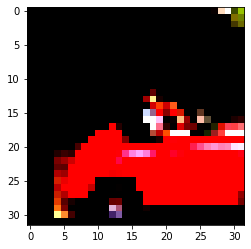

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


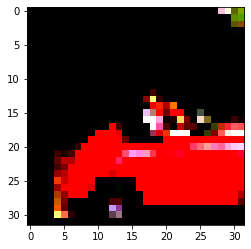

In [186]:
epsilon = .11
i = random.randint(0,100)
# i = 1


normal_inpt = trainset[i][0].reshape(1,3,32,32).cuda()
normal_inpt.requires_grad_(True)
out = net(normal_inpt)

target = torch.tensor([trainset[i][1]]).cuda()

loss = criterion(out, target)

optimizer.zero_grad()
loss.backward()

with torch.no_grad():
    advers_inp = normal_inpt + (epsilon * normal_inpt.grad.sign())
    advers_out = net(advers_inp)
    normal_out = net(normal_inpt)
    _,advs_predicted = torch.max(advers_out.cpu().data, 1)
    _,normal_predicted = torch.max(normal_out.cpu().data, 1)
    
print(f'true labels is {target.item()} \n adversaliral predicted is {advs_predicted} \n nomral is predicted{normal_predicted}')

imshow(normal_inpt.cpu().detach().squeeze())
imshow(advers_inp.cpu().detach().squeeze())

In [264]:
# advers_out = net(advers_inp) #+ (epsilon * normal_inpt.grad.sign())
# print(advers_out)
mx = 100
for j in range(1000):
    i = random.randint(0,3000)
    if torch.min(torch.min(trainset[i][0], -1)[0], -1)[0][0] < mx:
        mx = torch.min(torch.min(trainset[i][0], -1)[0], -1)[0][0]
mx

tensor(-2.4291)

In [372]:
import pandas as pd

df = pd.read_csv("./results/log_ResNet_Testing-oldmix-128-AdvsTrain-Eps(.32, .08)_10.csv")
df.iloc[164:]

,epoch,train loss,reg loss,train acc,test loss,test acc
164,6,1.301916,0.0,tensor(60.5883),0.712514,tensor(78.0100)
165,0,2.298722,0.0,tensor(12.6802),2.113369,tensor(24.5900)
166,1,2.252757,0.0,tensor(15.3536),2.069959,tensor(28.1700)
167,2,2.240661,0.0,tensor(16.2444),2.004672,tensor(29.0700)
168,3,2.230700,0.0,tensor(16.5389),1.969765,tensor(32.3400)
169,4,2.222991,0.0,tensor(17.3271),1.928990,tensor(35.0100)
170,5,2.213773,0.0,tensor(17.5534),1.926177,tensor(32.9400)
171,6,2.206603,0.0,tensor(17.7764),1.880987,tensor(36.9800)
172,7,2.197471,0.0,tensor(18.4282),1.871755,tensor(38.1100)
173,8,2.196829,0.0,tensor(18.5326),1.861002,tensor(38.8500)


In [371]:
df.iloc[45:71]

,epoch,train loss,reg loss,train acc,test loss,test acc
45,1,2.178418,0.0,tensor(19.4255),1.871926,tensor(33.5900)
46,2,2.067753,0.0,tensor(24.6385),1.804842,tensor(34.8200)
47,3,1.988595,0.0,tensor(28.3213),1.592738,tensor(43.4500)
48,4,1.930640,0.0,tensor(31.2297),1.521312,tensor(47.2000)
49,5,1.898096,0.0,tensor(32.9703),1.424092,tensor(50.9000)
50,6,1.851550,0.0,tensor(35.1109),1.396296,tensor(51.8400)
51,7,1.812248,0.0,tensor(37.2123),1.361482,tensor(54.0600)
52,8,1.762873,0.0,tensor(39.5908),1.267037,tensor(56.7700)
53,9,1.728539,0.0,tensor(41.5175),1.360291,tensor(52.8800)
54,10,1.661913,0.0,tensor(44.7768),1.451509,tensor(50.1900)
